 -------------------------------------------------------------------------------------------------------------- 

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
第1折 - 均方误差: 379.6812375706031, 平均绝对误差: 14.736769340065491, 平均绝对百分比误差: 20.532592774379214, 均方根误差: 19.48541089047401
第2折 - 均方误差: 581.82679453745, 平均绝对误差: 15.726396106276678, 平均绝对百分比误差: -45.76148229103569, 均方根误差: 24.12108609779937
第3折 - 均方误差: 239.78237243604585, 平均绝对误差: 12.481104412211096, 平均绝对百分比误差: 157.0846288066863, 均方根误差: 15.484907892397871
第4折 - 均方误差: 408.70801712377863, 平均绝对误差: 14.553610602383717, 平均绝对百分比误差: 55.961044230385426, 均方根误差: 20.21652831531118
第5折 - 均方误差: 389.36267778616644, 平均绝对误差: 14.344892278740604, 平均绝对百分比误差: 79.2278747245176, 均方根误差: 19.73227502814023
平均均方误差: 399.8722198908088
平均平均绝对误差: 14.368554547935517
平均平均绝对百分比误差: 53.408931648986574
平均均方根误差: 19.808041644824534


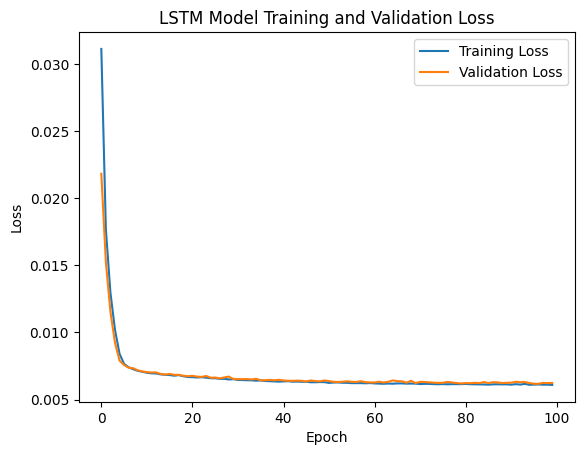

In [19]:
import pandas as pd
import numpy as np
from keras.models import Sequential, Model
from keras.layers import Input, LSTM, Dense  # 导入LSTM层相关模块，替换原来的RNN相关模块
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt


# 读取数据集
data = pd.read_csv("/kaggle/input/data12/data.csv")

# 提取相关特征列和目标列
features = data[['Total_Mean_Ground_Time', 'Mean_GROUND_Efficiency', 'Mean_FLIGHT_Efficiency']]
target = data['Total_Mean_Delay']

# 数据归一化
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
features_scaled = scaler_x.fit_transform(features)
target_scaled = scaler_y.fit_transform(target.values.reshape(-1, 1))

# 构建序列数据，假设时间步长为30，可按需调整
time_steps = 14
X = []
y = []
for i in range(len(features_scaled) - time_steps):
    X.append(features_scaled[i:i + time_steps])
    y.append(target_scaled[i + time_steps])
X = np.array(X)
y = np.array(y)

# 定义5折交叉验证
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
mse_scores = []
mae_scores = []
mape_scores = []
rmse_scores = []

# 用于存储每次折叠训练过程中的损失值，方便后续绘制损失曲线
all_train_losses = []
all_val_losses = []

for train_index, test_index in kfold.split(X):
    # 划分训练集和测试集
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # 使用Input层定义输入形状
    input_layer = Input(shape=(time_steps, 3))
    # 构建LSTM模型
    lstm_layer = LSTM(4, return_sequences=False)(input_layer)  # 使用LSTM层替代原来的SimpleRNNCell和RNN组合，设置神经元数量为20，只返回最后一个时间步输出
    output = Dense(1)(lstm_layer)

    model = Model(inputs=input_layer, outputs=output)

    # 使用Adam优化器
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    # 学习率下降策略
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=20, min_lr=0.0001)

    # 用于存储当前折叠训练过程中每一轮的训练集和验证集损失
    train_losses = []
    val_losses = []
    # 训练模型
    epochs = 100
    batch_size = 32
    for epoch in range(epochs):
        history = model.fit(X_train, y_train, epochs=1, batch_size=batch_size,
                            validation_data=(X_test, y_test), verbose=0, callbacks=[reduce_lr])
        train_loss = history.history['loss'][0]
        val_loss = history.history['val_loss'][0]
        train_losses.append(train_loss)
        val_losses.append(val_loss)

    all_train_losses.append(train_losses)
    all_val_losses.append(val_losses)

    # 预测
    y_pred = model.predict(X_test)
    # 逆归一化还原真实值
    y_pred_original = scaler_y.inverse_transform(y_pred)
    y_test_original = scaler_y.inverse_transform(y_test)

    # 计算均方误差并记录
    mse = mean_squared_error(y_test_original, y_pred_original)
    mse_scores.append(mse)

    # 计算平均绝对误差并记录
    mae = mean_absolute_error(y_test_original, y_pred_original)
    mae_scores.append(mae)

    # 计算平均绝对百分比误差并记录，注意需要处理分母为0的情况
    diff = np.abs(y_test_original - y_pred_original)
    divide = np.where(y_test_original == 0, 1.0e-10, y_test_original)
    mape = np.mean(diff / divide) * 100
    mape_scores.append(mape)

    # 计算均方根误差并记录
    rmse = np.sqrt(mse)
    rmse_scores.append(rmse)

# 输出每次折叠的均方误差、平均绝对误差、平均绝对百分比误差和均方根误差
for i, (mse, mae, mape, rmse) in enumerate(zip(mse_scores, mae_scores, mape_scores, rmse_scores)):
    print(f"第{i + 1}折 - 均方误差: {mse}, 平均绝对误差: {mae}, 平均绝对百分比误差: {mape}, 均方根误差: {rmse}")
print("平均均方误差:", np.mean(mse_scores))
print("平均平均绝对误差:", np.mean(mae_scores))
print("平均平均绝对百分比误差:", np.mean(mape_scores))
print("平均均方根误差:", np.mean(rmse_scores))

# 绘制损失曲线
avg_train_losses = np.mean(all_train_losses, axis=0)
avg_val_losses = np.mean(all_val_losses, axis=0)
plt.plot(avg_train_losses, label='Training Loss')
plt.plot(avg_val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('LSTM Model Training and Validation Loss')  # 修改标题体现是LSTM模型
plt.legend()
plt.show()

In [20]:
import matplotlib.pyplot as plt
from keras.utils import plot_model

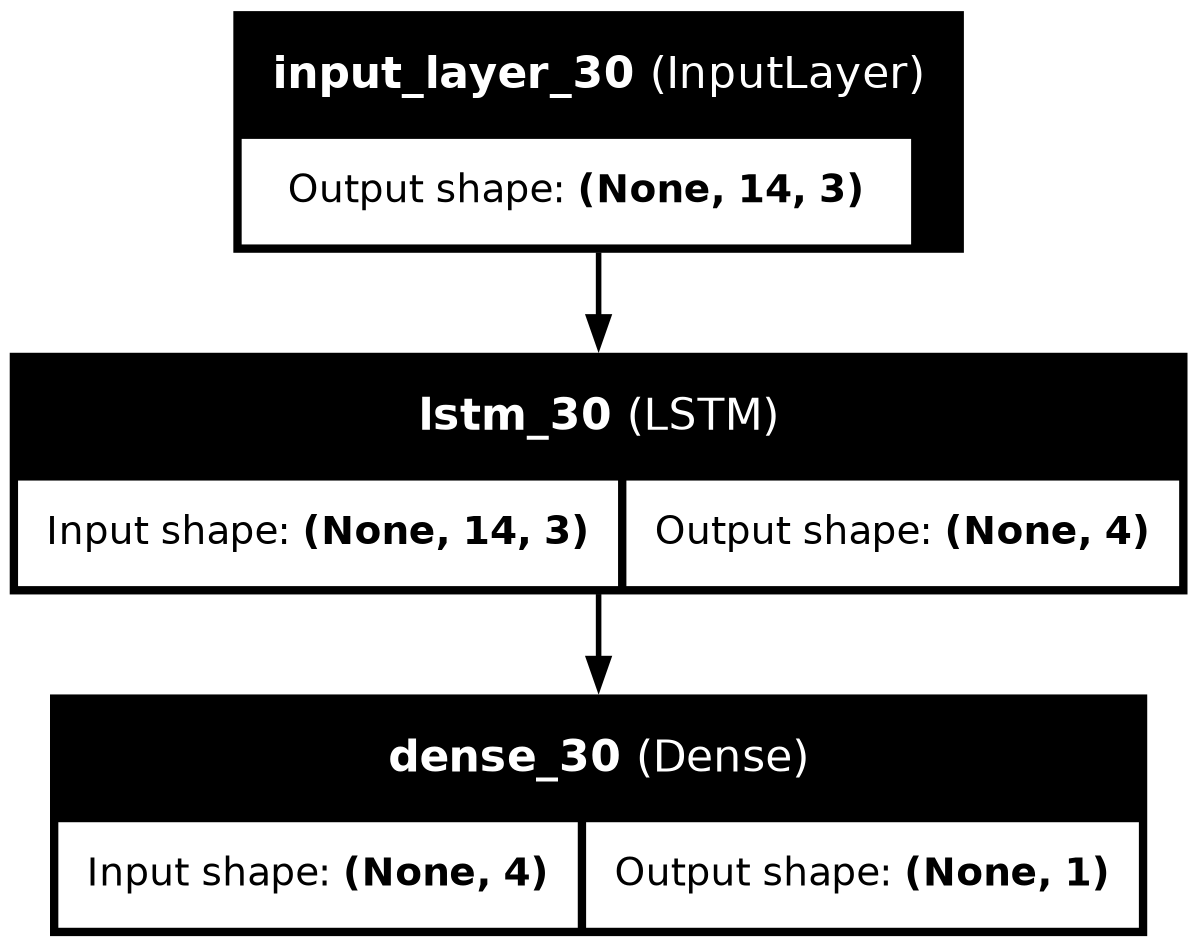

In [21]:
plot_model(model, to_file='lstm_model_structure.png', show_shapes=True, show_layer_names=True)

 ----------------------------------------------------------------------------